#Embeddings
Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:



In [ ]:
!gdown https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph&export=download
!unzip archive.zip

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph 

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/hw_embeddings.zip

Archive:  /content/drive/MyDrive/hw_embeddings.zip
  inflating: training.1600000.processed.noemoticon.csv  


Импортируем нужные библиотеки:

In [ ]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import nltk
import gensim
import gensim.downloader as api

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin', header=None,
                   names=['emotion', 'id', 'date', 'flag', 'user', 'text'])

Посмотрим на данные:

In [ ]:
data.head()

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.shape

(1600000, 6)

In [ ]:
data.sample(10)

,emotion,id,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
379611,0,2052380495,Sat Jun 06 00:32:16 PDT 2009,NO_QUERY,Yengching,Going to miss Pastor's sermon on Faith...
1189018,4,1983449090,Sun May 31 13:10:36 PDT 2009,NO_QUERY,jessig06,on lunch....dj should come eat with me
667030,0,2245479748,Fri Jun 19 16:11:29 PDT 2009,NO_QUERY,felicityfuller,@piginthepoke oh why are you feeling like that?
93541,0,1770705699,Mon May 11 22:01:32 PDT 2009,NO_QUERY,stephiiheyy,gahh noo!peyton needs to live!this is horrible
1097326,4,1970386589,Sat May 30 03:39:34 PDT 2009,NO_QUERY,wyndwitch,@mrstessyman thank you glad you like it! There...


In [ ]:
data['emotion'].unique()

array([0, 4])

Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [ ]:
examples = data['text'].sample(10)
print('\n'.join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [ ]:
data.shape[0]

1600000

In [ ]:
# all_texts = np.array(data['text'])
num_samples = data.shape[0]
idxs = np.random.permutation(num_samples)
threshold = int(0.8 * num_samples)
dev_data = data.iloc[idxs[:threshold]]
test_data = data.iloc[idxs[threshold:]]
dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [ ]:
dev_data.head()

,emotion,id,date,flag,user,text
0,0,1564500154,Mon Apr 20 03:47:08 PDT 2009,NO_QUERY,zourzouvillys,@Claire_Nelson i'm on the north devon coast th...
1,4,1957039896,Thu May 28 23:21:01 PDT 2009,NO_QUERY,twinkleval,@jhicks i will think of you on Sunday! Who ...
2,4,1557601862,Sun Apr 19 05:03:53 PDT 2009,NO_QUERY,andrewbulloch,Out in the garden with the kids debating wheth...
3,4,1823599026,Sat May 16 22:25:01 PDT 2009,NO_QUERY,vikchopra,@FrVerona thank u my love...u've shown me the ...
4,4,2186814798,Mon Jun 15 19:22:35 PDT 2009,NO_QUERY,jobrofan16,is with @jonasbrosfan1 going to buy LVATT tog...


In [ ]:
dev_data.shape

(1280000, 6)

#Обработка текста
Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

tokens = [token for sent in dev_data for token in word_tokenize(sent.lower()) if len(token) >= 4 and all(c not in string.punctuation for c in token)]

In [ ]:
ex_tokens = [token for token in word_tokenize(dev_data['text'][0].lower()) if len(token) > 3 and all(c not in string.punctuation for c in token)]
ex_tokens

['north',
 'devon',
 'coast',
 'next',
 'weeks',
 'will',
 'down',
 'devon',
 'again',
 'sometime',
 'hope',
 'though']

In [ ]:
dev_data['text'][0]

"@Claire_Nelson i'm on the north devon coast the next few weeks  will be down in Devon again in may sometime i hope though!"

Загрузим предобученную модель эмбеддингов.

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для слов. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [ ]:
word2vec = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1661.4/1662.8MB downloaded


In [ ]:
emb_line = [word2vec.get_vector(token) for token in ex_tokens if token in word2vec]
print(emb_line[0], sum(emb_line), sep='\n')

[-0.04541016 -0.13769531  0.03027344 -0.09277344  0.13867188  0.12451172
 -0.23730469 -0.38085938 -0.15820312  0.30273438  0.13378906  0.11767578
  0.06640625  0.09277344  0.00405884 -0.18945312 -0.17382812  0.05761719
  0.08691406 -0.06933594 -0.0135498  -0.00915527 -0.20996094  0.01855469
  0.29296875 -0.16113281 -0.10400391  0.04736328  0.16308594 -0.04541016
  0.19140625  0.09570312 -0.06445312 -0.1953125  -0.18261719  0.1328125
  0.1484375   0.07568359  0.09228516  0.14746094 -0.26953125 -0.05175781
 -0.00823975 -0.02075195 -0.23828125  0.0291748   0.07470703  0.11572266
 -0.10546875 -0.0534668   0.28125    -0.01879883  0.0859375  -0.16308594
 -0.26171875 -0.07470703 -0.14746094  0.06347656 -0.02624512  0.03564453
 -0.11816406 -0.09472656  0.11572266 -0.29492188  0.04663086 -0.13085938
 -0.16210938  0.16308594 -0.10449219  0.09423828  0.20898438 -0.00427246
  0.02258301  0.10888672 -0.03808594 -0.05126953 -0.18847656 -0.14453125
 -0.0189209   0.18652344  0.171875    0.09277344  0.

In [ ]:
print(len(emb_line), len(emb_line[0]), len(ex_tokens))

12 300 12


Нормализуем эмбеддинги, прежде чем обучать на них сеть. (наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [ ]:
mean = np.mean(word2vec.vectors, axis=0)
std = np.std(word2vec.vectors, axis=0)
norm_emb_line = [(word2vec.get_vector(token) - mean) / std for token in ex_tokens if token in word2vec]
print(norm_emb_line[0])

[-0.36991876 -1.1144205   0.33723447 -0.9588026   1.1273683   1.2655668
 -1.9674411  -2.7535336  -1.407751    2.0157566   1.0789026   0.9672879
  0.75316405  0.39632148  0.36060232 -1.7889175  -1.4717835   0.17459501
  0.94938695 -0.4929434  -0.33380184 -0.10436177 -1.9580019  -0.00657426
  2.205025   -1.0275367  -0.57802504  0.02593389  1.1787171  -0.00386162
  1.8159279   1.1199601  -0.5735491  -1.2923956  -1.5046108   1.6144451
  0.8970211   0.56526595  0.7400202   1.0215237  -2.1214437  -0.21194394
 -0.35803986 -0.57250845 -1.5004324   0.82210857  0.96930104  1.157132
 -0.8558387  -0.7845281   2.59623    -0.41671082  0.620433   -1.2972343
 -1.8676931  -0.94398654 -0.6751018   0.76095426 -0.04707284  0.85723877
 -0.54040086 -1.100693    1.3792686  -2.44836     0.3181613  -0.71763
 -1.2228173   1.172842   -1.2429638   0.22888167  1.5276442   0.2097967
  0.06393608  0.72415596  0.50153834  0.10216274 -1.8983116  -0.38632882
 -0.5099888   1.344879    1.5710814   1.1010938   0.76619905 

In [ ]:
print(mean)

[-2.25728611e-04 -1.01306627e-03 -1.04773864e-02  3.14636230e-02
  1.94908399e-03 -4.83569540e-02  8.71036202e-03 -4.18831371e-02
  2.51461826e-02  4.58311923e-02  1.26088806e-03 -1.75505376e-03
 -2.50608157e-02  4.20754105e-02 -4.06269804e-02  2.94472519e-02
  1.80458277e-02  3.59841287e-02 -2.66128872e-02 -7.92622752e-03
  2.70865131e-02  4.24901256e-03  5.27169220e-02  1.93178728e-02
  5.10774646e-03 -2.76226867e-02 -3.38717587e-02  4.39997353e-02
  1.32414782e-02 -4.49229591e-02 -3.05306613e-02 -4.27834578e-02
  4.64673946e-03 -2.74249297e-02  3.94795975e-03 -7.11372793e-02
  3.72331291e-02  7.20562087e-03  3.08779557e-03  8.44953489e-03
 -8.02358240e-03 -2.38431450e-02  4.02598381e-02  5.37732914e-02
 -4.63994108e-02 -7.93176889e-02 -4.39509153e-02 -1.62945110e-02
  7.95037951e-03  4.17706594e-02 -6.89574629e-02  3.71620990e-02
 -1.33652124e-03 -3.44692520e-03 -2.54474003e-02  4.80561107e-02
 -5.85142039e-02 -2.87780259e-02 -2.02133898e-02 -6.87459335e-02
 -4.95392196e-02  4.56381

Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [ ]:
from torch.utils.data import Dataset, random_split
from nltk import WordPunctTokenizer


class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = WordPunctTokenizer()

        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получи все токены из текста и профильтруй их
        return [word for word in self.tokenizer.tokenize(text.lower()) if all(c not in string.punctuation for c in word) and len(word) > 3]

    def get_embeddings_(self, tokens):
        # Получи эмбеддинги слов и усредни их
        embeddings = [(self.word2vec.get_vector(word) - self.mean) / self.std for word in tokens if word in self.word2vec]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
           # if len(embeddings.shape) == 1:
           #     embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
dev = TwitterDataset(dev_data, 'text', 'emotion', word2vec)

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

#Average embedding (2 балла)

Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предложении (которые остались после токенизации и удаления коротких слов, конечно).

In [ ]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev[i]["feature"], axis=0) for i in example_indexes],
            "targets": [dev[i]["target"] for i in example_indexes]}
print(len(examples["features"]))


1280


In [ ]:
type(examples['features'][0])

In [ ]:
examples['features'][0]

Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью PCA. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduc = pca.fit_transform(examples['features'])

In [ ]:
reduc[2]

array([ 2.37397934, -0.35610217])

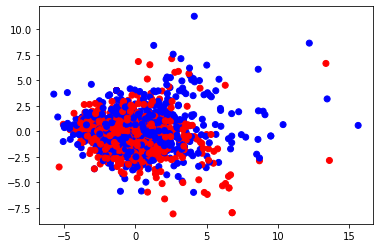

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=reduc[:, 0], y=reduc[:, 1], c=[['red', 'blue'][t] for t in examples['targets']])

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(
    reduc[:, 0],
    reduc[:, 1],
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1003', ...)

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит пренадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных. Усреднее векторов будем делать в "батчевалке"(collate_fn). Она используется для того, чтобы собирать из данных torch.Tensor батчи, которые можно отправлять в модель.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}

train_size = math.ceil(0.8*len(dev))
train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
val_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)


Определим функции для тренировки и теста модели:

In [ ]:
from tqdm.notebook import tqdm

def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):
    pbar = tqdm(train_loader, desc=f"Epoch {e + 1}. Train Loss: {0}")
    model.train()

    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        # Получи предсказания модели
        # Посчитай лосс
        # Обнови параметры модели
        optimizer.zero_grad()

        logits = model(features)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {e + 1}. Train Loss: {loss:.4}")


def testing(model, criterion, test_loader, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")

    mean_loss = 0
    mean_acc = 0

    model.eval()
    with torch.no_grad():

        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)

            # Получи предсказания модели
            # Посчитай лосс
            # Посчитай точность модели

            logits = model(features)
            loss = criterion(logits, targets)
            acc = (logits.argmax(dim=1) == targets).type(torch.float).mean()

            mean_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.

In [ ]:
class SimpleNNet(nn.Module):

  def __init__(self, emb_dim, n_classes):
    super(SimpleNNet, self).__init__()
    self.l1 = nn.Linear(emb_dim, 200)
    self.l2 = nn.Linear(200, 128)
    self.l3 = nn.Linear(128, 32)
    self.l4 = nn.Linear(32, n_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.l1(x))
    x = self.relu(self.l2(x))
    x = self.relu(self.l3(x))
    x = self.l4(x)

    return x



In [ ]:
import torch.nn as nn
from torch.optim import Adam, AdamW
torch.cuda.empty_cache()

vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-3
num_epochs = 2

print(vector_size)

model = SimpleNNet(emb_dim=vector_size, n_classes=num_classes)
model = model.to(device)
optimizer = AdamW(model.parameters(), weight_decay=0.1, lr=lr)
criterion = nn.CrossEntropyLoss()


300


Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?

In [ ]:
best_result = 0
for e in range(num_epochs):
  training(model, optimizer, criterion, train_loader, e, device)
  test_res = testing(model, criterion, val_loader, device)
  print(f'test res: {test_res}')
  if test_res['Test Acc'] > best_result:
    best_result = test_res['Test Acc']
    torch.save(model.state_dict(), "model.pt")




Epoch 1. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

test res: {'Test Loss': 0.5083959572315216, 'Test Acc': 0.7475}


Epoch 2. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

test res: {'Test Loss': 0.4975156818628311, 'Test Acc': 0.755734375}


In [ ]:
test_loader = DataLoader(TwitterDataset(test_data, 'text', 'emotion', word2vec),
                           batch_size=batch_size,
                           num_workers=num_workers,
                           shuffle=False,
                           drop_last=False,
                           collate_fn=average_emb)

model.load_state_dict(torch.load('model.pt', map_location=device))
print(testing(model, criterion, test_loader, device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.49910881486944497, 'Test Acc': 0.7540248103035144}


#Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалось – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:

Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)

Для каждого слова текста получим его эмбеддинг из Tfidf с помощью TfidfVectorizer из sklearn. Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующий эмбеддинг будет просто полученный из Tfidf. (4 балла)
Реализуйте оба варианта ниже. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

##1-ый вариант

In [ ]:
class TwitterDataset_1(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, window_size=1):
        self.tokenizer = WordPunctTokenizer()
        self.window_size = window_size
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получи все токены из текста и профильтруй их
        return [word for word in self.tokenizer.tokenize(text.lower()) if all(c not in string.punctuation for c in word) and len(word) > 3]

    def get_embeddings_(self, tokens):
        # Получи эмбеддинги слов и усредни их

        embeddings = [(self.word2vec.get_vector(word) - self.mean) / self.std for word in tokens if word in self.word2vec]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings != len(tokens)):
              for i in range(len(tokens)):
                if tokens[i] not in self.word2vec:
                  if 2 <= i <= len(embeddings) - 3:
                    embs = sum([embeddings[j] for j in range(i - 2, i + 3)])
                  else:
                    j = max(0, i - 2)
                    k = min(i + 2, len(embeddings) - 1)
                    embs = sum([embeddings[j] for j in range(j, k + 1)])
                  embeddings = np.insert(embeddings, i, embs, axis=0)
                i += 1



        return embeddings

        '''
        embeddings = []

        for i, word in enumerate(tokens):
            if word not in self.word2vec: # если слова нет среди предобученных эмбеддингов, расчитываем его эмбеддинг по его контенту
                left_context = max(0, i - self.window_size)
                right_context = min(len(tokens) - 1, i + self.window_size)

                context = tokens[left_context: i] + tokens[i + 1: right_context]
                embedding = [(self.word2vec.get_vector(context_word) - self.mean) / self.std for context_word in context if context_word in self.word2vec]

                if not len(embedding):
                    embedding = np.zeros(self.word2vec.vector_size)
                else:
                    embedding = np.sum(embedding, axis=0)

                embeddings.append(embedding)
            else:
                embeddings.append((self.word2vec.get_vector(word) - self.mean) / self.std)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings
        '''




      #  if len(embeddings) == 0:
       #     embeddings = np.zeros((1, self.word2vec.vector_size))
       # else:
       #     embeddings = np.array(embeddings)
       #     if len(embeddings.shape) == 1:
       #         embeddings = embeddings.reshape(-1, 1)

       # return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
dev_1 = TwitterDataset_1(dev_data, 'text', 'emotion', word2vec, 2)

In [ ]:
train_size = math.ceil(0.8*len(dev_1))
train, valid = random_split(dev_1, [train_size, len(dev_1) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
val_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
torch.cuda.empty_cache()
model_1 = SimpleNNet(emb_dim=vector_size, n_classes=num_classes)
model_1 = model.to(device)
optimizer_1 = AdamW(model_1.parameters(), weight_decay=0.1, lr=lr)
criterion_1 = nn.CrossEntropyLoss()

In [ ]:
dev_1.__getitem__(1)

{'feature': array([[-0.41419262,  1.9283851 ,  2.014323  , ..., -3.2890456 ,
         -1.5645111 , -1.7003472 ],
        [ 0.40159726,  1.3698087 ,  1.4848171 , ..., -1.6771787 ,
         -0.55704194, -1.0419474 ],
        [-0.38191125,  0.5536756 ,  0.16398586, ...,  0.13022426,
          0.8179045 , -0.5436422 ],
        [-0.43387863,  0.00490082,  0.36551994, ..., -1.7420911 ,
         -1.8253735 , -0.11475748]], dtype=float32), 'target': 1}

In [ ]:
best_metric = 0
for e in range(num_epochs):
  training(model_1, optimizer_1, criterion_1, train_loader, e, device)
  test_res = testing(model_1, criterion_1, val_loader, device)
  print(f'test res: {test_res}')
  if test_res['Test Acc'] > best_metric:
    best_metric = test_res['Test Acc']
    torch.save(model_1.state_dict(), "model_v1.pt")

Epoch 1. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

test res: {'Test Loss': 0.5030762758255005, 'Test Acc': 0.75240234375}


Epoch 2. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

test res: {'Test Loss': 0.500691398024559, 'Test Acc': 0.75273828125}


In [ ]:
test_loader_1 = DataLoader(TwitterDataset_1(test_data, 'text', 'emotion', word2vec, 2),
                           batch_size=batch_size,
                           num_workers=num_workers,
                           shuffle=False,
                           drop_last=False,
                           collate_fn=average_emb)

model_1.load_state_dict(torch.load('model_v1.pt', map_location=device))
print(testing(model_1, criterion, test_loader_1, device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.5032277432874369, 'Test Acc': 0.7514258436501597}


##2-й вариант

In [ ]:
!pip install sparsesvd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sparsesvd: filename=sparsesvd-0.2.2-cp38-cp38-linux_x86_64.whl size=442465 sha256=b2c965a1c25cbe3347834ec5c93ace251c61e9a0b76655120c180b87bb599c51
  Stored in directory: /root/.cache/pip/wheels/9a/90/46/8ba8493c6eaa5343837a43aad621862d76fdb5b8434c588c26
Successfully built sparsesvd


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sparsesvd import sparsesvd

def get_tfidf_embeddings(data, embedding_size=300):
  vectorizer = TfidfVectorizer(min_df=5)
  sparse_tfidf_mx = vectorizer.fit_transform(data)
  u, x, vt = sparsesvd(sparse_tfidf_mx.tocsc(), embedding_size)
  words, v = vectorizer.get_feature_names(), vt.T
  return {words[i] : v[i] for i in range(len(v))}


In [ ]:
class TwitterDataset_2(TwitterDataset):
  def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, tfidf_embeddings):
    super(TwitterDataset_2, self).__init__(data, feature_column, target_column, word2vec)
    self.tfidf_embeddings = tfidf_embeddings

  def get_embeddings(self, tokens):
    embeddings = []
    for token in tokens:
      if token not in self.word2vec:
        if token in self.tfidf_embeddings:
          embeddings.append((self.tfidf_embeddings[token] - self.mean) / self.std)
      elif token not in self.tfidf_embeddings:
        embeddings.append((self.word2vec.get_vector(token) - self.mean) / self.std)
      else:
        embeddings.append((self.word2vec.get_vector(token) + self.tfidf_embeddings(token) - self.mean) / self.std)

     # embeddings.append((self.word2vec.get_vector(token) * (token in self.word2vec) + self.tfidf_embeddings[token] * (token in self.tfifd_embeddings) - self.mean) / self.std)
    if len(embeddings) == 0:
      embeddings = np.zeros((1, self.word2vec.vector_size))
    else:
      embeddings = np.array(embeddings)

    return embeddings




In [ ]:
tfidf_embs = get_tfidf_embeddings(data['text'].values, 300)


In [ ]:
dev_2 = TwitterDataset_2(dev_data, 'text', 'emotion', word2vec, tfidf_embs)

train_idx = math.ceil(0.8 * len(dev_2))

batch_size = 1024
num_workers = 4

train_2, valid_2 = random_split(dev_2, [train_idx, len(dev_2) - train_idx])

train_loader_2 = DataLoader(train_2, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader_2 = DataLoader(valid_2, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
from torch.optim import AdamW
vector_size = dev_2.word2vec.vector_size
num_classes = 2
lr = 1e-3
num_epochs = 2

print(vector_size)

model_2 = SimpleNNet(emb_dim=vector_size, n_classes=num_classes).to(device)
optimizer = AdamW(model_2.parameters(), weight_decay=0.1, lr=lr)
criterion = nn.CrossEntropyLoss()


In [ ]:
best_result = 0
for e in range(num_epochs):
  training(model_2, optimizer, criterion, train_loader_2, e, device)
  test_res = testing(model_2, criterion, valid_loader_2, device)
  print(f'test res: {test_res}')
  if test_res['Test Acc'] > best_result:
    best_result = test_res['Test Acc']
    torch.save(model_2.state_dict(), "model_v2.pt")

In [ ]:
test_loader_2 = DataLoader(TwitterDataset_2(test_data, 'text', 'emotion', word2vec, tfidf_embs),
                           batch_size=batch_size,
                           num_workers=num_workers,
                           shuffle=False,
                           drop_last=False,
                           collate_fn=average_emb)

model_2.load_state_dict(torch.load('model_v2.pt', map_location=device))
print(testing(model_2, criterion, test_loader_2, device))

#Вывод
###Оба варианта показали результат лучший, чем когда мы вообще не учитывали слово. Оно и понятно - мы теряли часть информации. В то же время второй вариант показал лучший результат, чем первый, так как tf-ifd-эмбеддинги берут во внимание весь корпус текста, соответсвтенно наблюдаем прирост информации